In [1]:
!pip install "../"

Processing /Users/amaghaei/Work/virtual_society_modeling_framework
  Created wheel for audience-modeling-toolbox: filename=audience_modeling_toolbox-0.0.1-py3-none-any.whl size=25030 sha256=faa5dbfa0b0fd6cf9b367334a563a159683ecf1d8e3af9dbd15cd3a22cf34e22
  Stored in directory: /private/var/folders/mw/ycv4jvm57xq4v089c5qks7kh0000gp/T/pip-ephem-wheel-cache-du_mjywm/wheels/0a/6f/63/66c4fba250b29959f29c7c0a58304fff94d284f1506e1ee708
Successfully built audience-modeling-toolbox
  Attempting uninstall: audience-modeling-toolbox
    Found existing installation: audience-modeling-toolbox 0.0.1
    Uninstalling audience-modeling-toolbox-0.0.1:
      Successfully uninstalled audience-modeling-toolbox-0.0.1


In [2]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, uniform_filter
import itertools

# Plotting
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Importing the package
import audience_modeling_toolbox
from audience_modeling_toolbox.model import MixtureOfExponentials
from audience_modeling_toolbox.report import RFReport, generate_report

%matplotlib notebook

# Synthesizing a impression logs

In the next we steps, we generate a random society and simulate a random advertising campaign in order to use that data for the virtual society modeling later in the notebook.

## Generate a random society

We start by Synthesizing a society of `population_size = 10000` indivituals with two media that they can get exposed to advertising on, which we call them `MEDIUM I` and `MEDIUM II`. This is done by choosing a random activity distribution function or ADF. For the example below we choose either a mixture of exponentials or power law functions based on our expectation of what the society should look like. Note that if the behavior of the society is known we can utilize that instead of choosing at random. Anyways, here we are just feeling lucky, so let us make our random society by randomly generating a society of users that follow our random ADF!

You should see the society table generated as a Pandas dataframe with a column called `user_id` and two columns corresponding to the random activity user in each medium. Therefore, the numbers in from of each user indicates how active each user is on `MEDIUM I` and `MEDIUM II` respectively.

In [21]:
# Generation of a random society for two media, "MEDIUM I" and "MEDIUM II"
population_size = 10000
media = ['MEDIUM I', 'MEDIUM II']

# Random activity distribution function
adf = MixtureOfExponentials.random(n_exps=6, n_dims=2, rng=np.random.default_rng(1234)).normalize()

# random society
society = adf.generate_virtual_society(
    population_size=population_size, 
    media_cols=media, 
    id_col="user_id", 
    mode="random",
    rng=np.random.default_rng(1234)
)

society.dataframe

,user_id,MEDIUM I,MEDIUM II
0,0,4.674109,0.430020
1,1,2.920263,0.270054
2,2,0.301584,0.110210
3,3,0.212679,0.340098
4,4,4.028858,0.272573
...,...,...,...
9995,9995,0.138336,1.000698
9996,9996,0.304709,1.519084
9997,9997,0.343742,0.433475
9998,9998,1.011999,0.049450


## Simulating a random campaign

Now that we have a society with their corresponding acitivities

In [5]:
# simulate a campaign with 400% on and 800% in each medium
grps = [4 * population_size, 8 * population_size]
impressions = society.simulate_impressions(grps, rng=np.random.default_rng(1234))

impressions

,user_id,media
0,997,MEDIUM I
1,2572,MEDIUM I
2,7488,MEDIUM I
3,9664,MEDIUM I
4,6764,MEDIUM I
...,...,...
79995,2223,MEDIUM II
79996,6947,MEDIUM II
79997,4667,MEDIUM II
79998,1749,MEDIUM II


In [6]:
def plot_2d_reach(rf_data, dim_cols, ax=None) :
    if ax is None:
        fig, ax = plt.subplots()

    freq_label_jump = 2
    tickrange = range(0, 21, freq_label_jump)
    ticklabels = [str(i) for i in range(0, 21, freq_label_jump)]
    ticklabels[-1] = ticklabels[-1] + "+"

    im = ax.imshow(rf_data,
                   norm=matplotlib.colors.LogNorm(),
                   vmin=1,
                   vmax=2.e3,
                   origin="lower"
                  )
    ax.set_ylabel(dim_cols[0])
    ax.set_xlabel(dim_cols[1])

    ax.set_xticks(tickrange)
    ax.set_xticklabels(ticklabels)
    ax.set_yticks(tickrange)
    ax.set_yticklabels(ticklabels)

    plt.gcf().colorbar(im, ax=ax)
    
    return ax

<IPython.core.display.Javascript object>


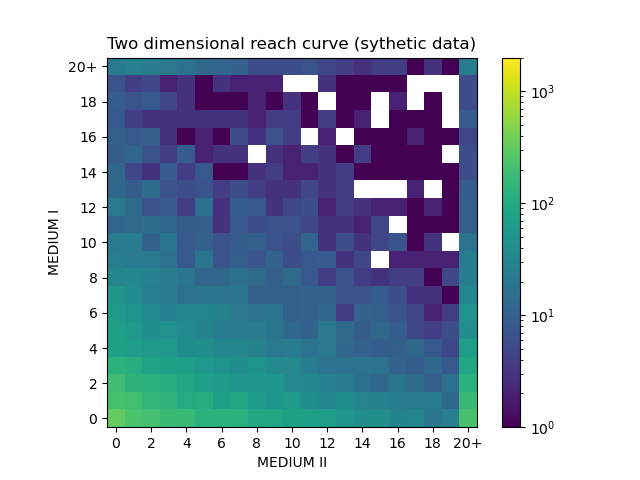

Text(0.5, 1.0, 'Two dimensional reach curve (sythetic data)')

In [7]:
report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="user_id")

# plot report
fig, ax = plt.subplots()
plot_2d_reach(report.pivot_to_dim_cols().values, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (sythetic data)")

# Training the activity distribution function

We now  train the activity distribution function (ADF) from the cross measurement report. The ADF is a distribution that explains the exposure berhavior of society. The `ftrunc_reach` method can calculate (predict) the multidimensional reach curve from a given ADF. For a detailed description of how it works, look at the "mathematical foundations of VID modeling" page in the documentation.

Note that ADF prediction is a smooth function compared to the noisy reality (and later on noisy VID)

<IPython.core.display.Javascript object>


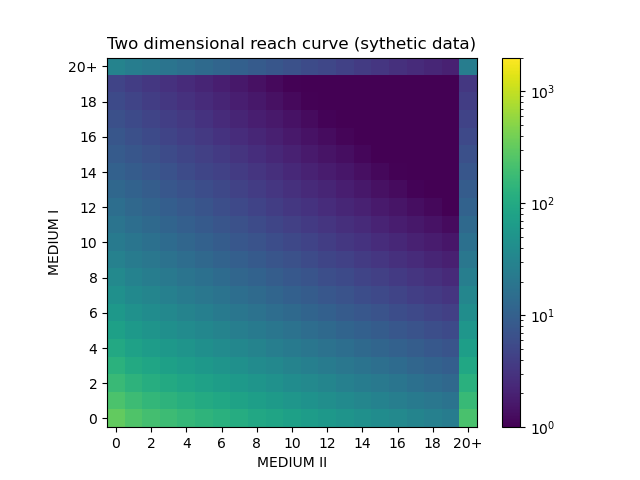

Text(0.5, 1.0, 'Two dimensional reach curve (sythetic data)')

In [8]:
adf = MixtureOfExponentials.random(n_exps=6, n_dims=2, rng=np.random.default_rng(1234))
adf.train(report)

# plot report
fig, ax = plt.subplots()
model_data = adf.ftrunc_reach(report.gr_values, max_freq=20).reshape([21, 21]) * population_size
plot_2d_reach(model_data, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (sythetic data)")

In [9]:
# Let us check to see if the distribution and acitivities are normalized
adf.normalization_info()
print(
    np.sum(adf.amplitudes * adf.parameters[0::2]),
    np.sum(adf.amplitudes * adf.parameters[1::2])
)

0.9804504584835853 1.0734339730068423


In [22]:
np.sum(adf.amplitudes)

1.0000000000000002

In [11]:
np.reshape(adf.parameters, [-1, 2])

array([[0.58823326, 0.9719362 ],
       [1.63851386, 0.74080665],
       [0.89833821, 6.39024337],
       [2.38281262, 3.7512875 ],
       [1.56042978, 0.70266082],
       [0.50245495, 0.0251763 ]])

In [12]:
virtual_society = adf.generate_virtual_society(
    population_size=population_size, 
    media_cols=media, 
    id_col="vid", 
    mode="uniform"
)


virtual_society.dataframe

,vid,MEDIUM I,MEDIUM II
0,0,0.008124,0.004773
1,1,0.008124,0.010040
2,2,0.008124,0.015850
3,3,0.008124,0.022245
4,4,0.008124,0.029246
...,...,...,...
9995,9995,6.368555,3.336682
9996,9996,6.368555,3.733610
9997,9997,6.368555,4.348285
9998,9998,6.368555,5.538113


# The multidimensional activity distribution of the society vs virtual society
Here we demonstrate at the activity distribution for a society compared to the activity distribution of the virtual society. It is obvious that while the two are following the same aggregate pattern, they are completely different societies. The most important point here is that while the activity of a normal society looks like a random distribution, we pick the virtual society to follow a specific uniform pattern that still follows the aggregate strucutre of the original society.

<IPython.core.display.Javascript object>


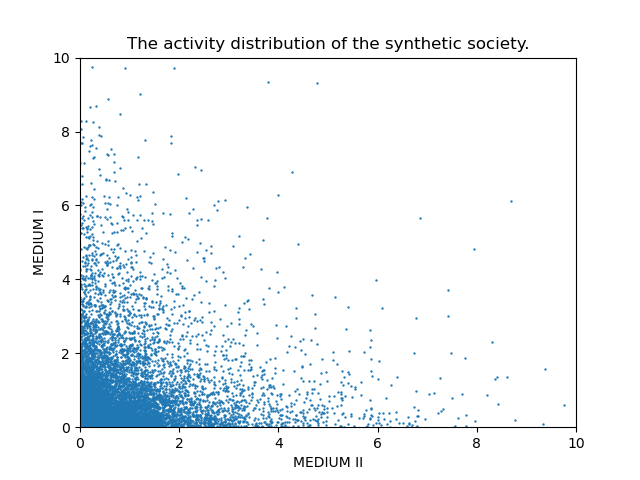

Text(0.5, 1.0, 'The activity distribution of the synthetic society.')

In [13]:
fig, ax = plt.subplots()
society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', style='o', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the synthetic society.")

<IPython.core.display.Javascript object>


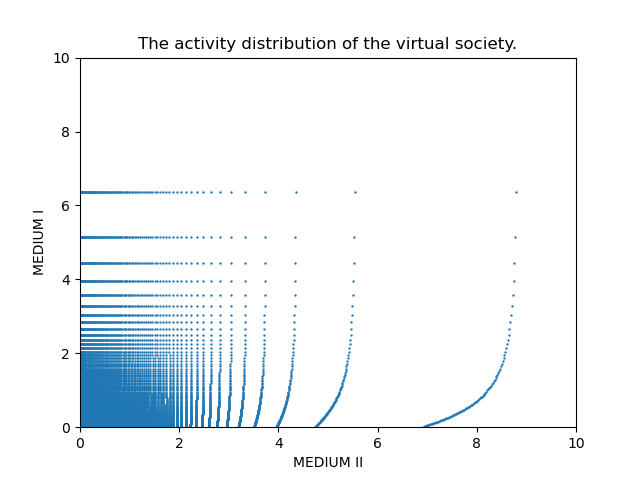

Text(0.5, 1.0, 'The activity distribution of the virtual society.')

In [14]:
fig, ax = plt.subplots()
virtual_society.dataframe.plot(x='MEDIUM II', y='MEDIUM I', kind='scatter', s=0.5, ax=ax)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_title("The activity distribution of the virtual society.")

impressions

In [15]:
vid_impressions = virtual_society.assign_impressions(impressions)

In [16]:
impressions

,user_id,media,probability,vid
0,997,MEDIUM I,0.301868,7084
1,2572,MEDIUM I,0.557595,8759
2,7488,MEDIUM I,0.089067,4267
3,9664,MEDIUM I,0.108890,4664
4,6764,MEDIUM I,0.556754,8763
...,...,...,...,...
79995,2223,MEDIUM II,0.019531,1121
79996,6947,MEDIUM II,0.658965,3291
79997,4667,MEDIUM II,0.872460,498
79998,1749,MEDIUM II,0.872020,398


# Generate the VID report

We will now make a report from the vid impressions and plot it to see how the the measruement campares with the measurement of the original society ...

<IPython.core.display.Javascript object>


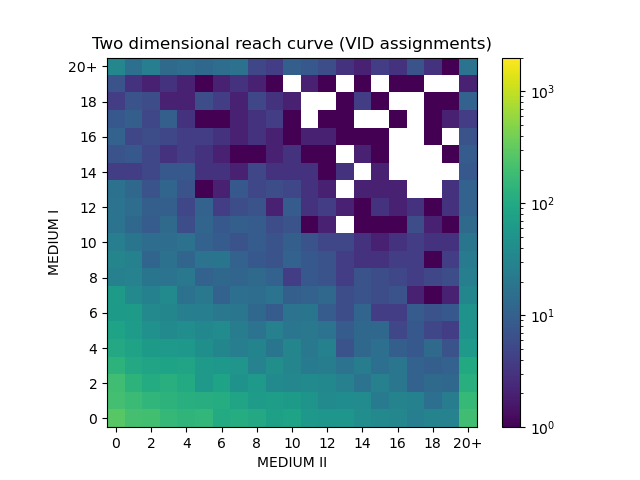

Text(0.5, 1.0, 'Two dimensional reach curve (VID assignments)')

In [17]:
vid_report = generate_report(impressions, population_size=population_size, max_freq=20, id_col="vid")

# plot report
fig, ax = plt.subplots()
plot_2d_reach(vid_report.pivot_to_dim_cols().values, dim_cols=media, ax=ax)
ax.set_title("Two dimensional reach curve (VID assignments)")

# Errors in the report generated by VID vs the original cross screen report
Below we inverstigate the multidimensional frequency reach surface error between the mneasurement report of the original society vs the report that was generated by the VID assigned to the impression table.

The first plot is the relative error between mutlidimensional reach over the range of 0 to 20+ frequencies. The error shows a noisey result specifically for higher frequencies. We also plot the error with a gaussian filter to show that the error is relatively small across the multi-frequency reach curve.

However, the important factors such as reach, overlap reach, and exclusive reach is shown to have a very reasonable accuracy, so the modelling correctly predicts the parameters of interest to ad campaign measurement.


<IPython.core.display.Javascript object>


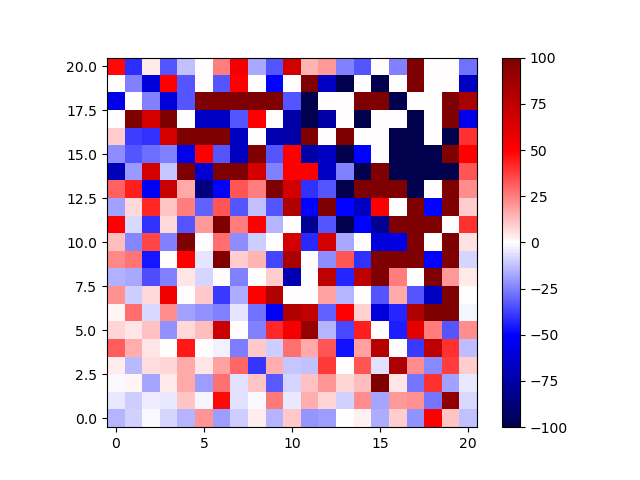

In [18]:
# Error across the multidimensional frequency domain
error = 100*(vid_report.pivot_to_dim_cols().values - report.pivot_to_dim_cols().values)/report.pivot_to_dim_cols().values

# clean up for the error matrix
error = np.nan_to_num(error, nan=0, posinf=100, neginf=-100)
error[error > 100] = 100
error[error < -100] = -100


fig, ax = plt.subplots()
im = ax.imshow(error,
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)

<IPython.core.display.Javascript object>


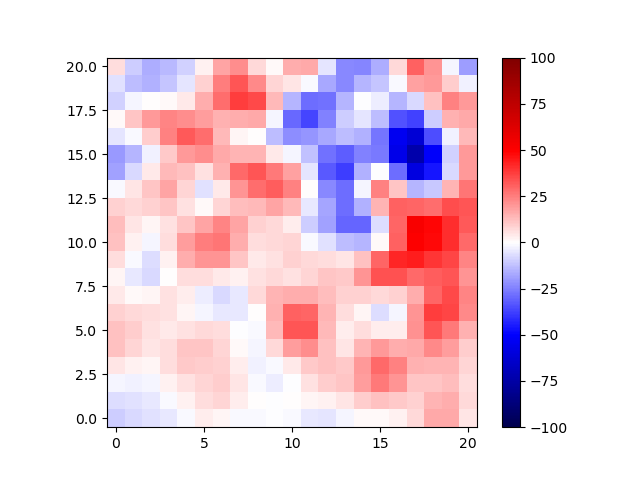

In [19]:
# Apply a gaussian filter with sigma of 1 to smooth out the multi-frequency curve
fig, ax = plt.subplots()
im = ax.imshow(gaussian_filter(error, 1),
           vmin=100,
           vmax=-100,
           cmap='seismic',
           origin="lower")
fig.colorbar(im, ax=ax)

In [20]:
# Error of the reach, exclusive reach, and overlap
report_data     = report.pivot_to_dim_cols(max_freq=1).values
vid_report_data = vid_report.pivot_to_dim_cols(max_freq=1).values

report_data[0, 0] = population_size - report_data[0, 0] 
vid_report_data[0, 0] = population_size - vid_report_data[0, 0] 

error_2 = np.round(100*(report_data - vid_report_data) / report_data, decimals=2)

print(f"Relative error in TOTAL REACH of both media is      % {error_2[0, 0]}")
print(f"Relative error in EXCLUSIVE REACH of MEDIUM I       % {error_2[1, 0]}")
print(f"Relative error in EXCLUSIVE REACH of MEDIUM II      % {error_2[0, 1]}")
print(f"Relative error in OVERLAP REACH of both media is    % {error_2[1, 1]}")

Relative error in TOTAL REACH of both media is      % -0.49
Relative error in EXCLUSIVE REACH of MEDIUM I       % -3.94
Relative error in EXCLUSIVE REACH of MEDIUM II      % 6.31
Relative error in OVERLAP REACH of both media is    % -2.04
